In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cycler import cycler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
import xgboost as xgb ## install xgboost if not installed

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview

- Question
    - **What features did contribute for customers to be repeaters?**
    - **Can we predict if a customer will be a repeater?**
    - This task is binary classification, using the `repeater` label in `df_train`.
 
- Current situation
    - Repeaters constitute only 3% of the total.
    - The dataset is imbalanced.
    - I plan to use `SMOTE` to address this issue.
 
- Models
    - Logistic linear regression model.
    - Random forest
    - XGBoost

- Possible reasons for customers not becoming repeaters (my hypothesis):
    - Dissatisfaction with the initial purchase experience (late product delivery, issues with the product or packaging based on customer reviews/score)
    - Customer have promotion, so they use olist. Without it, they don't. The question is, why didn't this lead to a second purchase?
    - The time span between the first and second purchase for repeaters
    - Differences in the categories of products purchased (ex: repeaters buy daily necessities, while others buy gadgets?)

## 1. Load data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_train.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(96095, 25)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## 2. Prepare df_numeric

In [3]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 12)


,frequency,repeater,recency,monetary,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,160,141.90,141.90,1,1,-5.0,5.0,0.0,1,1
1,1,0,163,27.19,27.19,1,1,-5.0,4.0,0.0,1,1
2,1,0,585,86.22,86.22,1,1,-2.0,3.0,0.0,1,0
3,1,0,369,43.62,43.62,1,1,-12.0,4.0,0.0,1,0
4,1,0,336,196.89,196.89,1,1,-8.0,5.0,0.0,1,1


In [4]:
## X should contain information about the first purchase, not RFM stuff.
X = df_numeric.drop(['repeater', 'frequency', 'recency', 'monetary'], axis=1)
y = df_numeric['repeater']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (92633, 8)
y shape: (92633,)


## Functions to train model and get results

In [5]:
def train_model_and_get_result(X, y, model, name, is_lf):
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    ## Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy')

    ## Get the Importance of the Features
    pipeline.fit(X, y)
    model = pipeline.named_steps['model']
    feature_names = X.columns
    importances = model.coef_[0] if is_lf else model.feature_importances_

    result = {
        'name': name,
        'mean_accuracy': accuracies.mean(),
        'std_accuracy': accuracies.std(),
        'accuracies': accuracies,
        'feature_importance': {'features': feature_names, 'importances': importances}
    }

    return result

def print_result(result):
    print("=== Result Summary ===")
    print(f"Mean Accuracy: {result['mean_accuracy']:.4f}")
    print(f"Std Accuracy: {result['std_accuracy']:.4f}")
    print(f"Accuracies: {result['accuracies']}")

    feature_importances = pd.DataFrame({
        'Feature': result['feature_importance']['features'],
        'Importance': result['feature_importance']['importances']
    })
    feature_importances = feature_importances. \
        sort_values(by='Importance', ascending=False). \
        reset_index(drop=True)

    print("\n=== Feature Importance ===")
    print(feature_importances.to_string(index=False))

## Logistic Regression

In [6]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
result_lr = train_model_and_get_result(X, y, model_lr, "LogisticRegression", is_lf=True)

print_result(result_lr)

=== Result Summary ===
Mean Accuracy: 0.6192
Std Accuracy: 0.0140
Accuracies: [0.62028391 0.62195714 0.59270254 0.62830616 0.6326784 ]

=== Feature Importance ===
                 Feature  Importance
         fo_voucher_used    0.577863
    fo_review_score_mean    0.097562
fo_voucher_payment_value    0.000932
        fo_payment_value   -0.000593
  fo_delivery_delay_days   -0.001452
           fo_is_weekday   -0.684866
   customer_in_sao_paulo   -0.831019
           fo_is_daytime   -0.865057


**Interpretation of Result Summary**
- **Mean CV Accuracy**: The average accuracy across the five folds is approximately 66.23%, indicating that, on average, the model correctly predicts whether a customer will be a repeater about two-thirds of the time.
- **Variability**: The standard deviation of the CV accuracy scores is about 6.21%, showing a moderate variation in the model's performance across different folds. This variation can be attributed to the diversity of data in each fold or intrinsic differences in the difficulty of predicting certain subsets of the data.
- **Range of Accuracy Scores**: The accuracy scores across folds range from approximately 56.73% to 74.10%, highlighting the inconsistent performance of the model across different segments of the dataset.

**Interpretation of Feature Importance**
- `fo_voucher_used`
  - The most influential positive feature, suggesting that customers who used a voucher in their first order are more likely to repeat.
- `fo_is_weekday`
  - Customers who make their first order on a weekday are less likely to repeat, with a significant negative influence.
- `fo_is_daytime`
  - Similar to fo_is_weekday, orders made during daytime have a notably negative effect on repeat probability.
- `customer_in_sao_paulo`
  - Shows no effect

**Next Steps**
- Although binary classification is used in `fo_is_weekday` and `fo_is_daytime`, more detailed classification by time or day of the week could improve the performance of the model.
- We can also drop `customer_in_sao_paulo` as it has no effect on the repeater probability.
- Add intersection terms

## Random Forest

In [7]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
result_rf = train_model_and_get_result(X, y, model_rf, "RandomForest", is_lf=False)

print_result(result_rf)

=== Result Summary ===
Mean Accuracy: 0.9322
Std Accuracy: 0.0016
Accuracies: [0.92950829 0.93366438 0.93139742 0.93295908 0.93344489]

=== Feature Importance ===
                 Feature  Importance
        fo_payment_value    0.349420
  fo_delivery_delay_days    0.304206
    fo_review_score_mean    0.258748
   customer_in_sao_paulo    0.031605
           fo_is_weekday    0.022153
           fo_is_daytime    0.019376
fo_voucher_payment_value    0.014493
         fo_voucher_used    0.000000


**Interpretation of Result Summary**
- The mean accuracy is higher than Logistic Regression, at approximately 66.23%.
  - Main reason is Random Forest is a non-linear model. We have some binary features, so the performance can be better than Logistic Regression. 

**Interpretation of Feature Importance**
- There are no significant feature that impact the model performance.
- Again, customer_in_sao_paulo has no effect.

**Next Steps**
- Drop `customer_in_sao_paulo` and `fo_voucher_used`.

## XGBoost

In [8]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
result_xgb = train_model_and_get_result(X, y, model_xgb, "XGBoost", is_lf=False)

print_result(result_xgb)

=== Result Summary ===
Mean Accuracy: 0.9431
Std Accuracy: 0.0021
Accuracies: [0.93992551 0.94208453 0.94613267 0.94321494 0.94413257]

=== Feature Importance ===
                 Feature  Importance
    fo_review_score_mean    0.449575
   customer_in_sao_paulo    0.181713
  fo_delivery_delay_days    0.142827
           fo_is_daytime    0.088326
           fo_is_weekday    0.082071
        fo_payment_value    0.038195
fo_voucher_payment_value    0.017293
         fo_voucher_used    0.000000


**Interpretation of Result Summary**
- the accuracy is better than Random Forest. 

**Interpretation of Feature Importance**
- `fo_review_score_mean` is the most important feature.
- Same as Random Forest, `customer_in_sao_paulo` and `fo_voucher_used` has no effect.

## Compare the 3 models

In [9]:
def plot_mean_accuracy(results):
    names = [result['name'] for result in results]
    mean_accuracies = [result['mean_accuracy'] for result in results]

    plt.bar(names, mean_accuracies)
    plt.xlabel('Model')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy Comparison')
    plt.show()


def combine_feature_importances(results):
    feature_names = results[0]['feature_importance']['features']
    combined = pd.DataFrame({'Feature': feature_names})

    for result in results:
        combined[result['name']] = result['feature_importance']['importances']

    return combined


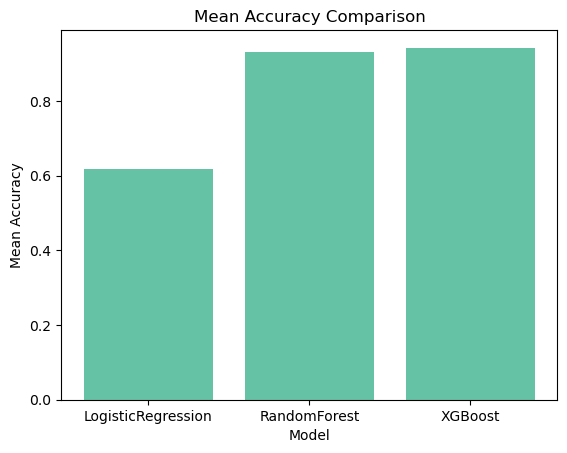

,Feature,LogisticRegression,RandomForest,XGBoost
0,fo_payment_value,-0.000593,0.349420,0.038195
1,fo_is_daytime,-0.865057,0.019376,0.088326
2,fo_is_weekday,-0.684866,0.022153,0.082071
3,fo_delivery_delay_days,-0.001452,0.304206,0.142827
4,fo_review_score_mean,0.097562,0.258748,0.449575
5,fo_voucher_payment_value,0.000932,0.014493,0.017293
6,fo_voucher_used,0.577863,0.000000,0.000000
7,customer_in_sao_paulo,-0.831019,0.031605,0.181713


In [10]:
results = [result_lr, result_rf, result_xgb]

plot_mean_accuracy(results)

combined_importances = combine_feature_importances(results)
combined_importances